# Evolent Health: Technical Exercise for Data Science Candidate

### **Imports**

In [1]:
import re
import warnings
from os import getcwd
from os.path import join, isfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from transformers import pipeline

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

### **Reading data**

In [3]:
DATA_DIR = join(getcwd(), "data")
data_file_path = join(DATA_DIR, "BeerDataScienceProject.csv")

In [4]:
df = pd.read_csv(data_file_path, encoding="iso-8859-1")

In [5]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508590 non-null  float64
 1   beer_beerId         528870 non-null  int64  
 2   beer_brewerId       528870 non-null  int64  
 3   beer_name           528870 non-null  object 
 4   beer_style          528870 non-null  object 
 5   review_appearance   528870 non-null  float64
 6   review_palette      528870 non-null  float64
 7   review_overall      528870 non-null  float64
 8   review_taste        528870 non-null  float64
 9   review_profileName  528755 non-null  object 
 10  review_aroma        528870 non-null  float64
 11  review_text         528751 non-null  object 
 12  review_time         528870 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 52.5+ MB


,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
271029,9.2,24071,68,Gonzo Imperial Porter,Baltic Porter,4.0,3.5,3.0,3.5,lpayette,3.5,"12 oz bottle. 2006 vintage, enjoyed sometime i...",1171174420
487404,6.5,355,132,Dead Guy Ale,Maibock / Helles Bock,3.5,3.0,4.0,3.0,treehugger02010,4.0,A solid beer. I just had it from the Wild Onio...,1161549156
135781,10.0,31613,5318,Old Viscosity,American Double / Imperial Stout,4.0,3.0,4.5,3.5,photomike,4.0,"Pours a deep, dark, near black with a large an...",1247642197
189006,7.0,35732,2743,Green Flash Hop Head Red Ale,American Amber / Red Ale,4.5,4.0,4.0,4.5,cooncat,4.0,Got this one on tap at the UPICK6 Beer store i...,1252786112
500960,6.2,43969,132,Yellow Snow IPA,American IPA,4.5,4.5,4.5,4.5,OlRasputin989,4.5,Poured into nonic pint... A: a slightly hazy g...,1262061151


### **Missing Values**

In [6]:
df_na = df.dropna()
print(f"Percentage of values missing: {(1 - (df_na.shape[0] / df.shape[0])) * 100:.2f}%")

Percentage of values missing: 3.88%


### **Duplicate Values**

In [7]:
print(f"Total number of duplicate values: {df_na.shape[0] - df_na.drop_duplicates().shape[0]}")

Total number of duplicate values: 0


## **Question 1**: Top 3 breweries with strongest beer

In [8]:
average_alcohol_content = df_na.groupby(['beer_brewerId']).mean()['beer_ABV']
average_alcohol_content.head()

beer_brewerId
1     4.438717
3     5.537475
5     4.790072
10    4.973214
14    6.939831
Name: beer_ABV, dtype: float64

In [9]:
average_alcohol_content = average_alcohol_content.sort_values(ascending=False).head(20)
average_alcohol_content

beer_brewerId
6513     19.228824
736      13.750000
24215    12.466667
36       12.445860
8540     11.750000
5040     11.500000
10226    11.000000
19362    11.000000
3066     10.800000
19114    10.500000
517      10.500000
509      10.433333
5562     10.341176
3704     10.203333
2796     10.061806
25259    10.000000
12864    10.000000
207       9.925389
25668     9.800000
387       9.750000
Name: beer_ABV, dtype: float64

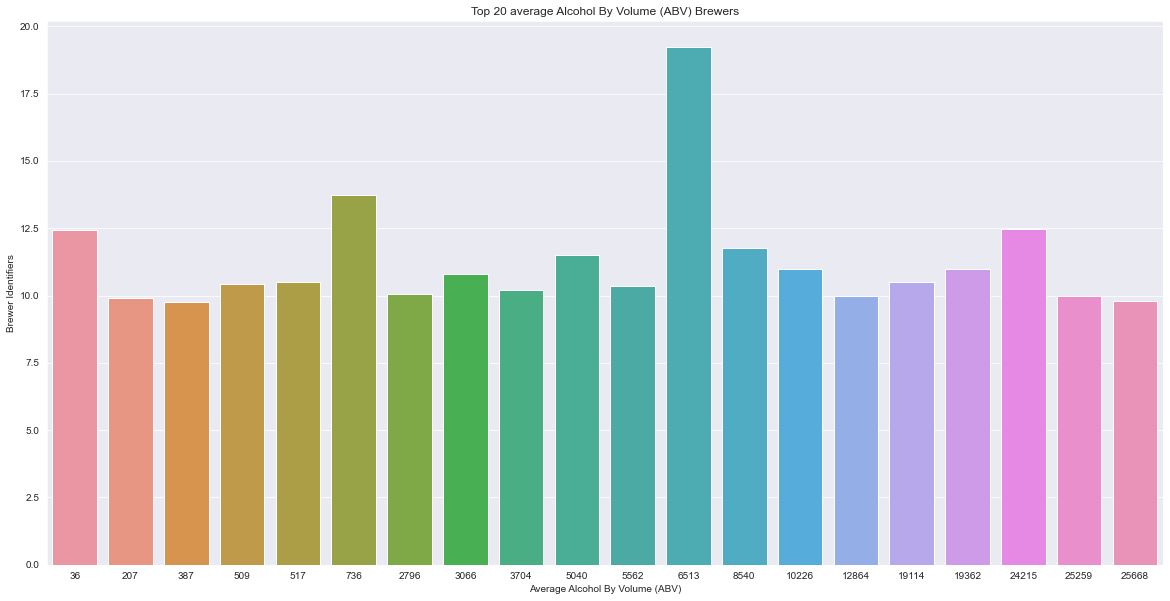

In [10]:
plt.figure(figsize=(20, 10))
plt.title("Top 20 average Alcohol By Volume (ABV) Brewers")
sns.barplot(average_alcohol_content.index, average_alcohol_content)
plt.xlabel("Average Alcohol By Volume (ABV)")
plt.ylabel("Brewer Identifiers")
plt.show()

In [11]:
del average_alcohol_content

## **Question 2**: Which year did beers enjoy the highest ratings?

In [12]:
df_na['year'] = pd.to_datetime(df_na['review_time'], unit='s').apply(lambda x: x.year)

In [13]:
average_rating = df_na.groupby('year').mean()['review_overall']
average_rating

year
1998    4.045455
1999    4.000000
2000    4.233333
2001    3.961896
2002    3.817551
2003    3.772793
2004    3.806632
2005    3.844657
2006    3.809104
2007    3.819879
2008    3.840345
2009    3.868749
2010    3.869430
2011    3.833394
2012    3.839082
Name: review_overall, dtype: float64

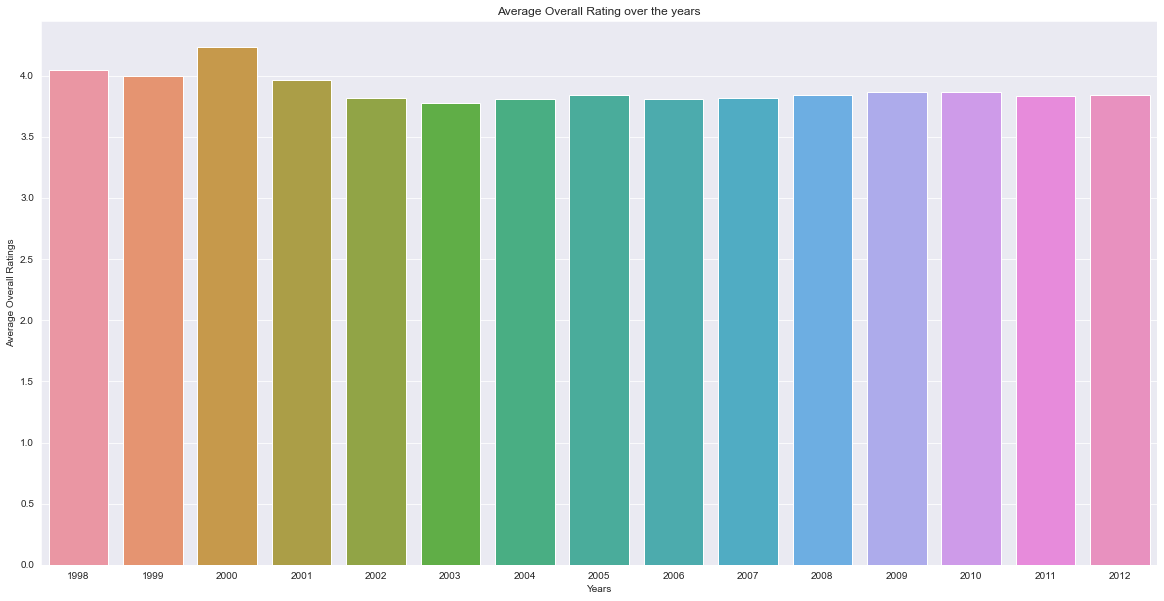

In [14]:
plt.figure(figsize=(20, 10))
plt.title("Average Overall Rating over the years")
sns.barplot(average_rating.index, average_rating)
plt.xlabel("Years")
plt.ylabel("Average Overall Ratings")
plt.show()

In [15]:
average_rating.sort_values(ascending=False).head()

year
2000    4.233333
1998    4.045455
1999    4.000000
2001    3.961896
2010    3.869430
Name: review_overall, dtype: float64

In [16]:
del average_rating

## **Question 3**: Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

In [17]:
rating_df = df_na[['review_appearance', 'review_aroma', 'review_palette',
                   'review_taste', 'review_overall']]
rating_df.sample(5)

,review_appearance,review_aroma,review_palette,review_taste,review_overall
334354,3.0,3.0,2.5,2.5,3.0
252521,4.0,2.0,2.5,3.0,2.5
116698,3.5,4.0,4.0,3.5,4.0
511925,4.0,3.5,3.5,4.0,4.0
32013,4.5,5.0,4.0,4.0,4.5


In [18]:
rating_correlation = rating_df.corr()
rating_correlation

,review_appearance,review_aroma,review_palette,review_taste,review_overall
review_appearance,1.000000,0.531204,0.544724,0.551979,0.483091
review_aroma,0.531204,1.000000,0.703428,0.722737,0.780310
review_palette,0.544724,0.703428,1.000000,0.600842,0.598048
review_taste,0.551979,0.722737,0.600842,1.000000,0.689276
review_overall,0.483091,0.780310,0.598048,0.689276,1.000000


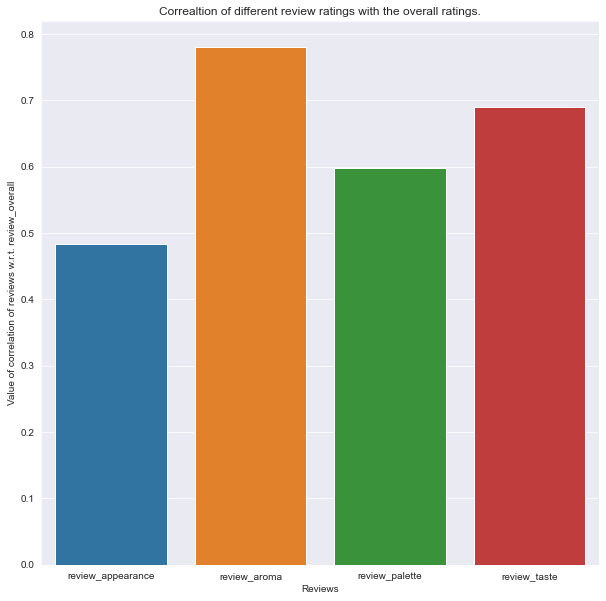

In [19]:
plt.figure(figsize=(10, 10))
plt.title("Correaltion of different review ratings with the overall ratings.")
sns.barplot(rating_correlation.index[:-1], rating_correlation.review_overall[:-1])
plt.xlabel("Reviews")
plt.ylabel("Value of correlation of reviews w.r.t. review_overall")
plt.show()

In [20]:
del rating_df, rating_correlation

## **Question 4**: If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

In [21]:
ratings_alcohol_columns = ['beer_ABV', 'review_appearance', 'review_aroma',
                           'review_palette', 'review_taste', 'review_overall']
rating_alcohol_df = df_na.groupby('beer_name').mean()[ratings_alcohol_columns]
rating_alcohol_df['num_reviews'] = df_na.groupby('beer_name').count()['review_text']
rating_alcohol_df[rating_alcohol_df.num_reviews >= 100].sort_values(by=['review_overall', 'beer_ABV'], ascending=False).iloc[:3]

,beer_ABV,review_appearance,review_aroma,review_palette,review_taste,review_overall,num_reviews
beer_name,,,,,,,
Citra DIPA,8.0,4.369048,4.573413,4.690476,4.373016,4.630952,252
Cantillon Blåbær Lambik,5.0,4.644231,4.628205,4.528846,4.493590,4.628205,156
Heady Topper,8.0,4.163113,4.608742,4.660981,4.405117,4.625800,469


In [22]:
del rating_alcohol_df, ratings_alcohol_columns

## **Question 5**: Which Beer style seems to be the favorite based on reviews written by users?

## **Question 6**: How does written review compare to overall review score for the beer styles?

In [23]:
# SentimentClassifier = pipeline('sentiment-analysis')
# SentimentClassifier = pipeline('sentiment-analysis', model='roberta-base')
sentiment_classifier = pipeline('sentiment-analysis', model="siebert/sentiment-roberta-large-english")

In [24]:
def get_sentiment_score(review: str):
    """
    Takes as input a review and returns a float value representing its sentiment.
    """
    try:
        sentiment_dict = sentiment_classifier(review)[0]
        if sentiment_dict['label'] == "NEGATIVE":
            return -1 * sentiment_dict['score']
        return sentiment_dict['score']
    except Exception:
        return np.nan

In [25]:
sentiment_file = join(DATA_DIR, "sentiment_sample_data.csv")

In [26]:
if isfile(sentiment_file):
    df_na_sample = pd.read_csv(sentiment_file, index_col='original_index')
else:
    df_na_sample = df_na.sample(10000)
    df_na_sample['sentiment_score'] = df_na_sample.review_text.apply(get_sentiment_score)
    df_na_sample.to_csv(sentiment_file)

df_na_sample = df_na_sample.dropna()
df_na_sample.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,sentiment_score
original_index,,,,,,,,,,,,,,,
128994,18.4,32963,848,XXX Warlock Double Imperial Stout,American Double / Imperial Stout,4.0,4.0,3.5,4.5,feloniousmonk,4.0,"XXX Warlock Double Imperial Stout, Bristol Bre...",1212123106,2008,0.997013
304814,5.2,8297,35,Samuel Adams White Ale,Witbier,4.0,3.5,3.5,3.5,edchicma,4.0,Nice cloudy appearance with a decent head and ...,1080409848,2004,0.998898
22970,8.3,11757,1199,Founders Breakfast Stout,American Double / Imperial Stout,2.5,3.0,4.5,2.0,HossMcGraw,4.5,Mixed feelings on this one; I've been anxiousl...,1318904349,2011,-0.999444
152488,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.5,5.0,5.0,5.0,CAMRAhardliner,5.0,"I got this at Bauer Wines a few weeks ago, tha...",1144806986,2006,0.998828
231347,6.1,26233,158,Fresh Hop Pale Ale,American Pale Ale (APA),4.0,3.5,3.5,4.0,gmcfarre,4.0,22 oz bomber poured into 25mL heineken glass A...,1181056945,2007,0.998445


In [27]:
df_na_sample.sentiment_score += 1
df_na_sample.sentiment_score *= (5 / 2)
df_na_sample.sentiment_score.head()

original_index
128994    4.992533
304814    4.997245
22970     0.001390
152488    4.997070
231347    4.996112
Name: sentiment_score, dtype: float64

<AxesSubplot:>

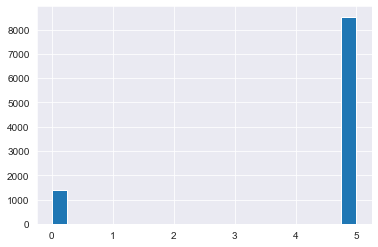

In [28]:
df_na_sample.sentiment_score.hist(bins=20)

In [29]:
sample_corr = df_na_sample.corr()
sample_corr.loc[['review_overall', 'sentiment_score'], ['review_overall', 'sentiment_score']]

,review_overall,sentiment_score
review_overall,1.000000,0.558378
sentiment_score,0.558378,1.000000


In [30]:
mean_squared_error(df_na_sample.review_overall, df_na_sample.sentiment_score)

2.346352758298453

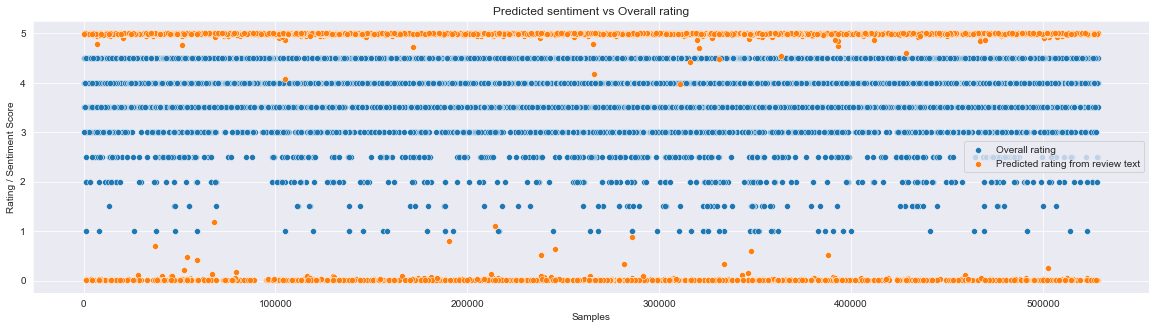

In [31]:
plt.figure(figsize=(20, 5))
plt.title("Predicted sentiment vs Overall rating")
sns.scatterplot(df_na_sample.index, df_na_sample.review_overall, label="Overall rating")
sns.scatterplot(df_na_sample.index, df_na_sample.sentiment_score, label="Predicted rating from review text")
plt.xlabel("Samples")
plt.ylabel("Rating / Sentiment Score")
plt.show()

In [32]:
del df_na_sample, sample_corr

## **Question 7**: How do find similar beer drinkers by using written reviews only?

The process, I will follow is as follows:
1. Preprocessing the text.
    1. Cleaning the data:
        - Converting to lower cases.
        - Expanding the contracted terms. 
        - Experiment with removing stopwords.
        > Note: Since we are tackling a problem of pattern recognition, removing the stopwords might change the pattern and reduce the performance of our model.
    2. Vectorisation
        - Finding 2-grams and 3-grams.
        - Creating TF vectors. 
        > Note: we can use TF-IDF vectors too. 
2. Training a unsuprevised model.
    1. I would like to train a hierarchical agglomerative clustering model. This type of model will allow us to select the number of cluster on the fly and therefore have flexibility.
    > Note: This is based on the assumption that the review about a particular beer will be writing same kind reviews. 
    2. I will also try topic modeling. This will allow us to find the topics the beer reviewrs are generally writing about.
    > Note: This methodology also has an assumption which is that the similar beer drinker will be reviewing about same topics in the reviews.